# *Importing Libraries*

In [3]:
import os
import cv2
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, matthews_corrcoef

# *Preprocessing*

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/New_Dataset/data_path.csv")
df.head()

In [ ]:
df.shape

In [ ]:
def read_images_from_df(df):
    images = []
    labels = []
    count = 1
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
        if count % 500 == 0:
            print(count)
        count += 1
    return images, labels

images, labels = read_images_from_df(df)

### Show sample

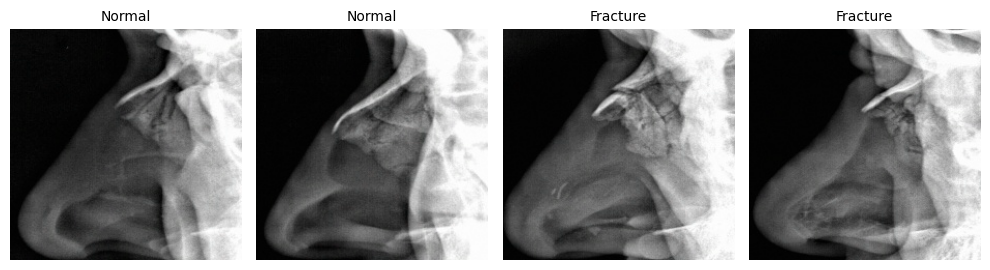

In [7]:
def show_smp(images, labels):
    fig, axes = plt.subplots(1, 4, figsize=(10, 8))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    for i in range(4):
        idx = 2 * i + 1474
        ax = axes[i]
        ax.imshow(images[idx])
        if labels[idx] == 0:
            label = 'Normal'
        else:
            label = 'Fracture'
        ax.set_title(label, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_smp(images, labels)

## *Split data on train val test*

In [8]:
X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(labels), test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [ ]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))
print()
print("shape of y_train is: {} ".format(y_train.shape))
print("shape of y_val is: {}".format(y_val.shape))
print("shape of y_test is: {}".format(y_test.shape))

## *Data Augmentation*

In [10]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(
    np.array(X_train),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
classes = np.unique(labels)
classes

In [ ]:
img, lable = train_generator.__next__()
img.shape

### Show sample:

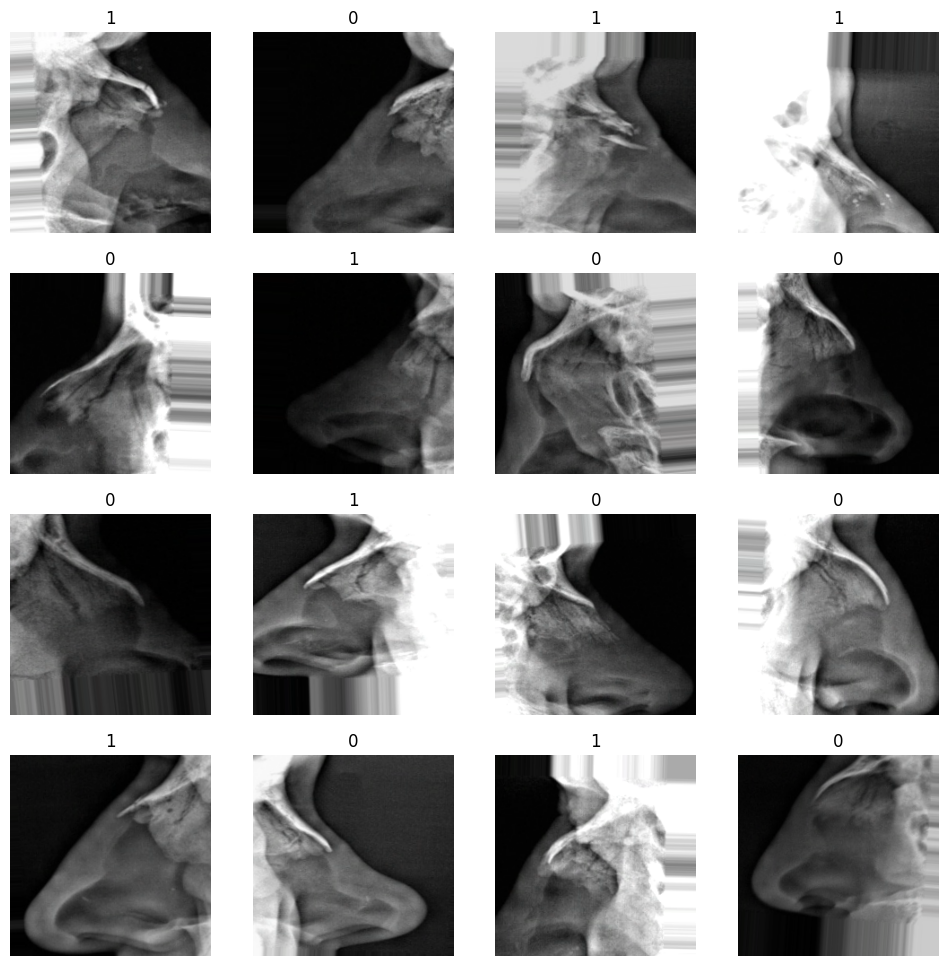

In [13]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.title(lable[i])
        plt.axis('off')
    plt.show()

show_sample(img, lable)

In [14]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='navy')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='navy')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()

    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss)))

In [15]:
def roc_auc_score_(y_test, y_pred):
    auc_ = roc_auc_score(y_test, y_pred)
    print("AUC:", auc_)
    print()

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='khaki', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
def confusion_matrix_(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.color_palette(["#FFFFFF", "#00004D"])

    class_labels = ['normal', 'fracture']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, linewidths=1.5,
                linecolor='black', xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted label", fontsize = 12, fontweight = 'bold')
    plt.ylabel("True label", fontsize = 12, fontweight = 'bold')
    plt.title(name, fontsize = 15, fontweight = 'bold')
    plt.show()

In [17]:
def metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f0_5_score = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
    f1_score = fbeta_score(y_test, y_pred, beta=1, average='weighted')
    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    mcc_score = matthews_corrcoef(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    output = (
        f"{'Metric':<15}{'Score':>10}\n"
        f"{'-'*25}\n"

        f"{'Sensitivity':<15}{sensitivity:>10.6f}\n"
        f"{'Specificity':<15}{specificity:>10.6f}\n"
        f"{'F0.5 Score':<15}{f0_5_score:>10.6f}\n"
        f"{'MCC Score':<15}{mcc_score:>10.6f}\n"

        f"{'.'*25}\n"

        f"{'Precision':<15}{precision:>10.6f}\n"
        f"{'Recall':<15}{recall:>10.6f}\n"
        f"{'F1 Score':<15}{f1_score:>10.6f}\n"
        f"{'F2 Score':<15}{f2_score:>10.6f}\n"
    )
    print(output)

In [18]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.92
    lr = initial_learning_rate * decay**(1.25 * epoch)
    if lr > 1e-4:
        return lr
    else:
        return 1e-4

lr_scheduler = LearningRateScheduler(lr_schedule)

---
## *Model*

In [19]:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

base_model.trainable = True
print("Number of layers in the base_model: ", len(base_model.layers))

In [21]:
for layer in base_model.layers[:60]:
    layer.trainable = False

In [22]:
model = Sequential([
    base_model,
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"),
    Flatten(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(512, 'relu'),
    Dropout(0.4),
    BatchNormalization(),
    Dense(64, 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(len(classes), "sigmoid")
])

model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 11520)               │          46,080 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,238,082 (31.43 MB)

 Trainable params: 8,115,650 (30.96 MB)

 Non-trainable params: 122,432 (478.25 KB)

In [24]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 84s 377ms/step - accuracy: 0.5303 - loss: 2.0998 - val_accuracy: 0.5506 - val_loss: 1.8394 - learning_rate: 5.0000e-04
Epoch 2/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.5267 - loss: 1.9453 - val_accuracy: 0.5730 - val_loss: 1.7449 - learning_rate: 4.5051e-04
Epoch 3/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.5687 - loss: 1.8167 - val_accuracy: 0.5281 - val_loss: 2.0202 - learning_rate: 4.0592e-04
Epoch 4/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.5576 - loss: 1.7731 - val_accuracy: 0.5079 - val_loss: 2.2434 - learning_rate: 3.6574e-04
Epoch 5/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - accuracy: 0.5532 - loss: 1.7885 - val_accuracy: 0.5034 - val_loss: 2.3522 - learning_rate: 3.2954e-04
Epoch 6/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 30s 231ms/step - accuracy: 0.5435 - loss: 1.7319 - val_accuracy: 0.5124 - val_loss: 2.4365 - learning_rate: 2.9692e-04
Epoch 7/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 42s 23

In [ ]:
draw_plot(hist)

In [26]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7536 - loss: 1.0802
Test accuracy : 74.66367483139038


In [27]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step


### *Classification report*

In [28]:
metrics(y_test, y_pred)

Metric              Score
-------------------------
Sensitivity      0.746637
Specificity      0.807860
F0.5 Score       0.747009
MCC Score        0.494512
.........................
Precision        0.749018
Recall           0.746637
F1 Score         0.745450
F2 Score         0.745600



In [29]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.73      0.81      0.77       229
    fracture       0.77      0.68      0.72       217

    accuracy                           0.75       446
   macro avg       0.75      0.74      0.74       446
weighted avg       0.75      0.75      0.75       446



### *Confusion matrix*

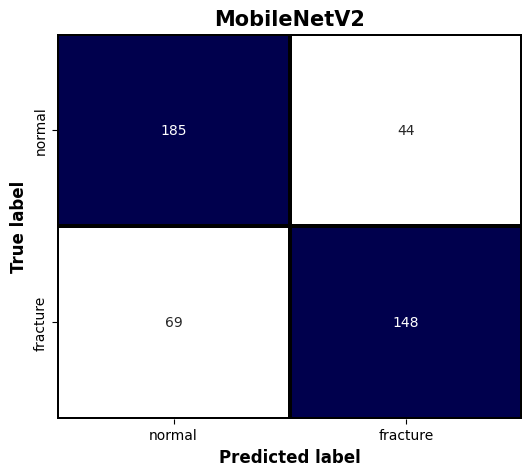

In [30]:
confusion_matrix_(y_test, y_pred, name="MobileNetV2")

### *ROC & AUC*

AUC: 0.7449439558891595



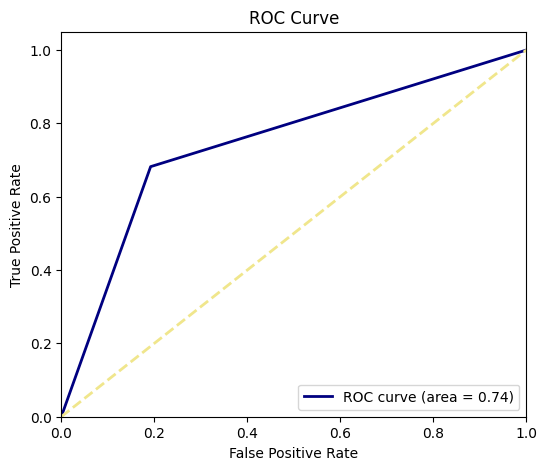

In [31]:
roc_auc_score_(y_test, y_pred)